### Detectron Bounding Box detector

To run everything succesfully find all data to download here: https://drive.google.com/drive/folders/1a57oWg4Uc-a8so5KbF4LiW9yb9PmVP3K?usp=sharing

FYI: for everything to run, you must place the downloaded data into a folder in directory path = data/ 

Usefull websites used as inspiration: 
- https://github.com/sushant097/Handwritten-Line-Text-Recognition-using-Deep-Learning-with-Tensorflow

- https://medium.com/swlh/learn-and-use-handwritten-line-text-recognition-using-deep-learning-with-tensorflow-b661434b5e3b

- https://github.com/NielsRogge/Transformers-Tutorials/tree/master/TrOCR

- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCRFine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb

- https://github.com/crazycloud/Handwritten-text-Detection-Detectron2/blob/master/2020-04-09-Handwritten%20Text%20Detection%20in%20Detectron2.ipynb


In [24]:
#Install Detectron
#!python -m pip install git+https://github.com/facebookresearch/detectron2.git --user

In [25]:
#library imports
import os 
import glob 
import time
import pandas as pd
from PIL import Image
import torch
import json
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
import random
import cv2
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultTrainer
from detectron2.engine import default_setup
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

#### Data preparation for training

In [26]:
path_to_csv = 'csvs/before_cleaned_data.csv'
df = pd.read_csv(path_to_csv, low_memory=False)
df = df.drop(columns= 'Unnamed: 0')
df

campo    x    y    w   h       text  \
0                                 fecha   42  106  124  21   4/1/2018   
1                                 fecha   42  106  156  21   2/7/2012   
2                                 fecha   42  109  101  18  14/1/1980   
3                                 fecha   42  109  101  18  14/1/1980   
4                                 fecha   42  109  101  18  14/1/1980   
...                                 ...  ...  ...  ...  ..        ...   
253872                              B 4  734  425   17  18          X   
253873                              B 3  731  393   15  14          X   
253874                              B 2  730  359    0   0              
253875                              B 1  733  330   16  12          X   
253876  A  aseguradora danos_propios_si  255  902    0   0              

                    jpg_file_name  
0        parte_amistoso_9_9_9.jpg  
1       parte_amistoso_0_23_3.jpg  
2       parte_amistoso_1_19_3.jpg  
3       parte_amistoso_1_20_3.jpg  
4       parte_amistoso_1_23_3.jpg  
...                           ...  
253872   parte_amistoso_9_9_9.jpg  
253873   parte_amistoso_9_9_9.jpg  
253874   parte_amistoso_9_9_9.jpg  
253875   parte_amistoso_9_9_9.jpg  
253876   parte_amistoso_9_9_9.jpg  

[253877 rows x 7 columns]

In [27]:
df.dtypes

campo            object
x                 int64
y                 int64
w                 int64
h                 int64
text             object
jpg_file_name    object
dtype: object

In [28]:
path_to_csv = 'csvs/classes.csv'
classes = pd.read_csv(path_to_csv, low_memory=False)
classes

Unnamed: 0                           classes  encoding
0             0            A  aseguradora agencia         0
1             1  A  aseguradora agencia direccion         1
2             2     A  aseguradora agencia nombre         2
3             3        A  aseguradora carta_verde         3
4             4  A  aseguradora carta_verde_desde         4
..          ...                               ...       ...
108         108                 localizacion pais       108
109         109                             lugar       109
110         110                          testigos       110
111         111                       victimas no       111
112         112                       victimas si       112

[113 rows x 3 columns]

In [29]:
list(classes['classes'])

['A  aseguradora agencia',
 'A  aseguradora agencia direccion',
 'A  aseguradora agencia nombre',
 'A  aseguradora carta_verde',
 'A  aseguradora carta_verde_desde',
 'A  aseguradora carta_verde_hasta',
 'A  aseguradora danos_propios_no',
 'A  aseguradora danos_propios_si',
 'A  aseguradora num_poliza',
 'A  aseguradora pais',
 'A  aseguradora telefono',
 'A  aseguradora_nombre',
 'A  conductor apellidos',
 'A  conductor categoria',
 'A  conductor danos_apreciados',
 'A  conductor direccion',
 'A  conductor fecha_nac',
 'A  conductor nombre',
 'A  conductor pais',
 'A  conductor permiso',
 'A  conductor telefono',
 'A  conductor valido_hasta',
 'A  remolque matricula',
 'A  remolque pais',
 'A  vehiculo marca_modelo',
 'A  vehiculo matricula',
 'A  vehiculo pais',
 'A 1',
 'A 10',
 'A 11',
 'A 12',
 'A 13',
 'A 14',
 'A 15',
 'A 16',
 'A 17',
 'A 2',
 'A 3',
 'A 4',
 'A 5',
 'A 6',
 'A 7',
 'A 8',
 'A 9',
 'A asegurado apellidos',
 'A asegurado codigo_postal',
 'A asegurado direccion',

In [30]:
# Classes to delete from dataset
delete = ['A 1','A 10','A 11','A 12','A 13','A 14','A 15','A 16',
          'A 17','A 2','A 3','A 4','A 5','A 6','A 7','A 8','A 9', 
          'A n_casillas','B 1','B 10','B 11','B 12','B 13','B 14',
          'B 15','B 16','B 17','B 2','B 3','B 4','B 5','B 6','B 7',
          'B 8','B 9', 'B n_casillas', 'A  aseguradora danos_propios_no',
          'A  aseguradora danos_propios_si', 'B aseguradora danos_propios no',
          'B aseguradora danos_propios si', 'victimas no', 'victimas si', 'danos_materiales objetos no',
        'danos_materiales objetos si', 'danos_materiales vehiculos si','danos_materiales vehículos no']


In [31]:
def remove_rows_with_value(df, column_name, value):
    new_df = df[df[column_name] != value]
    return new_df

new_df = df
new_classese = classes
for c in delete:
    new_df = remove_rows_with_value(new_df, 'campo', c)
    new_classese = remove_rows_with_value(new_classese, 'classes', c)

new_df
print(new_classese)

     Unnamed: 0                           classes  encoding
0             0            A  aseguradora agencia         0
1             1  A  aseguradora agencia direccion         1
2             2     A  aseguradora agencia nombre         2
3             3        A  aseguradora carta_verde         3
4             4  A  aseguradora carta_verde_desde         4
..          ...                               ...       ...
106         106                             fecha       106
107         107                              hora       107
108         108                 localizacion pais       108
109         109                             lugar       109
110         110                          testigos       110

[67 rows x 3 columns]


Encode all classes

In [32]:
le = LabelEncoder()

# fit and transform the 'campo' column
new_df['campo'] = le.fit_transform(new_df['campo'])

# print the encoding used for each label
classes = list(le.classes_)
encoding = list(le.transform(le.classes_))
print(classes)
print(encoding)

['A  aseguradora agencia', 'A  aseguradora agencia direccion', 'A  aseguradora agencia nombre', 'A  aseguradora carta_verde', 'A  aseguradora carta_verde_desde', 'A  aseguradora carta_verde_hasta', 'A  aseguradora num_poliza', 'A  aseguradora pais', 'A  aseguradora telefono', 'A  aseguradora_nombre', 'A  conductor apellidos', 'A  conductor categoria', 'A  conductor danos_apreciados', 'A  conductor direccion', 'A  conductor fecha_nac', 'A  conductor nombre', 'A  conductor pais', 'A  conductor permiso', 'A  conductor telefono', 'A  conductor valido_hasta', 'A  remolque matricula', 'A  remolque pais', 'A  vehiculo marca_modelo', 'A  vehiculo matricula', 'A  vehiculo pais', 'A asegurado apellidos', 'A asegurado codigo_postal', 'A asegurado direccion', 'A asegurado nombre', 'A asegurado pais', 'A asegurado telefono', 'B asegurado apellidos', 'B asegurado codigo_postal', 'B asegurado direccion', 'B asegurado nombre', 'B asegurado pais', 'B asegurado telefono', 'B aseguradora agencia', 'B ase

In [33]:
new_classese = pd.DataFrame({'classes': classes, 'encoding': encoding})
new_classese

classes  encoding
0             A  aseguradora agencia         0
1   A  aseguradora agencia direccion         1
2      A  aseguradora agencia nombre         2
3         A  aseguradora carta_verde         3
4   A  aseguradora carta_verde_desde         4
..                               ...       ...
62                             fecha        62
63                              hora        63
64                 localizacion pais        64
65                             lugar        65
66                          testigos        66

[67 rows x 2 columns]

#### Creating a dataset in coco format

In [34]:
def create_coco_dataset(data):
    grouped_data = data.groupby('jpg_file_name')
    dataset = []

    for file_name, group in grouped_data:
        annotations = []
        for _, row in group.iterrows():
            annotation = {
                'category_id': row['campo'],
                'bbox': [int(row['x']), int(row['y']), int(row['w']) if int(row['w']) > 0 else 1, int(row['h']) if int(row['h']) > 0 else 1],
                'bbox_mode': BoxMode.XYWH_ABS
            }
            annotations.append(annotation)

        img = Image.open(f'data/{file_name}')
        width, height = img.size

        image_data = {
            'file_name': f'data/{file_name}',
            'image_id': file_name.split('.')[0],
            'height': height,
            'width': width,
            'annotations': annotations
        }
        dataset.append(image_data)

    return dataset

def store_list_in_file(my_list, file_name):
    with open(file_name, 'w') as file:
        for item in my_list:
            json.dump(item, file)
            file.write('\n')

def load_list_from_file(file_name):
    my_list = []
    with open(file_name, 'r') as file:
        for line in file:
            my_list.append(json.loads(line))
    return my_list


#### Storing the new dataset in file bounding-box.txt

In [35]:
# my_list = create_coco_dataset(new_df)
# file_name = 'bounding-box.txt'

# store_list_in_file(my_list, file_name)

Visualizing encoded dataset

In [36]:
file_name = 'bounding-box.txt'
df = load_list_from_file(file_name)
len(df)

2226

In [37]:
# Function to visualize dataset from MetaData
def visualize_dataset(datasetname, n_samples=10):

    dataset_dicts = DatasetCatalog.get(datasetname)
    metadata = MetadataCatalog.get(datasetname)

    for d in random.sample(dataset_dicts,n_samples):
        print(d['file_name'])
        img = cv2.imread(d["file_name"])
        print(img)
        visualizer = Visualizer(img[:, :, ::-1],
        metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.axis("off")
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

In [38]:
# Function to split data in test and train
def split_data(lst, split):
    n = len(lst)
    n_20_percent = int(n * 0.05)
    n_80_percent = n - n_20_percent
    test = random.sample(lst, n_20_percent)
    train = [item for item in lst if item not in test]
    if split == 'train':
        return train
    
    if split == 'test':
        return test

In [39]:
# Function to register Dataset for model to train
def register_dataset(name, dirname):
    if name not in DatasetCatalog.list():
        DatasetCatalog.register(name, lambda: split_data(df, 'train'))
        
    MetadataCatalog.get(name).set(
        thing_classes=list(new_classese['classes']), split='train', dirname= dirname
    )

In [40]:
register_dataset('new_docs_dataset_train', dirname = 'datasets')

Visualizing encoded and ready to train data set, one sample

data/parte_amistoso_9_18_11.jpg
[[[236 236 236]
  [236 236 236]
  [231 231 231]
  ...
  [206 206 206]
  [208 208 208]
  [208 208 208]]

 [[236 236 236]
  [235 235 235]
  [230 230 230]
  ...
  [207 207 207]
  [209 209 209]
  [209 209 209]]

 [[234 234 234]
  [232 232 232]
  [229 229 229]
  ...
  [210 210 210]
  [212 212 212]
  [212 212 212]]

 ...

 [[224 224 224]
  [224 224 224]
  [225 225 225]
  ...
  [150 150 150]
  [149 149 149]
  [149 149 149]]

 [[224 224 224]
  [225 225 225]
  [226 226 226]
  ...
  [148 148 148]
  [147 147 147]
  [147 147 147]]

 [[224 224 224]
  [224 224 224]
  [226 226 226]
  ...
  [148 148 148]
  [146 146 146]
  [146 146 146]]]


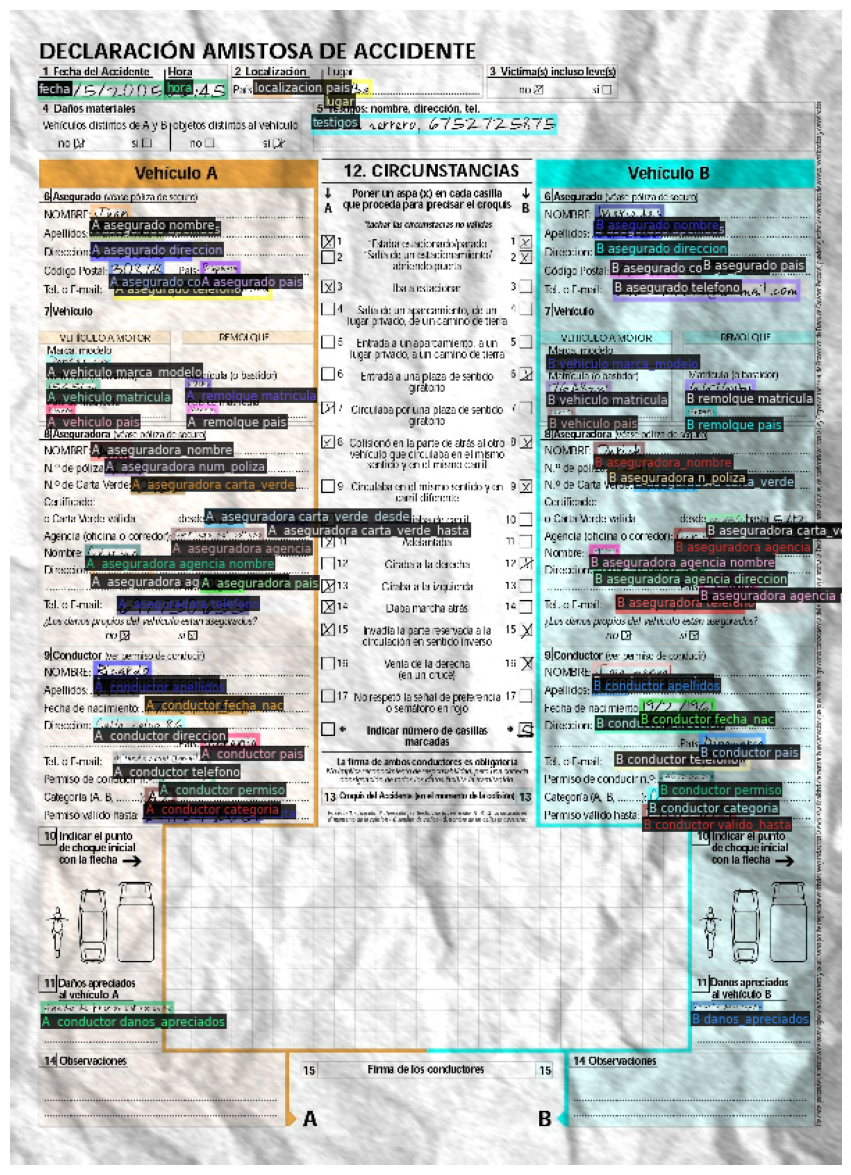

In [41]:
visualize_dataset('new_docs_dataset_train',n_samples = 1)

#### Setting up configs for Training

In [42]:
def setup_cfg(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-101.pkl"
    cfg.DATASETS.TRAIN = ("new_docs_dataset_train",)
    cfg.SOLVER.MAX_ITER = 15000
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 67
    # cfg.MODEL.DEVICE='cpu'
    cfg.freeze()
    default_setup(cfg, args)
    return cfg


parser = default_argument_parser() 
args = parser.parse_args("--config-file configs/faster_rcnn.yaml OUTPUT_DIR tuned-detectron".split())



Checking if GPU is available for training

In [43]:
import torch

if torch.cuda.is_available():
    print("GPU available")
else:
    print("GPU not available")

GPU available


#### Training

In [46]:
cfg = setup_cfg(args)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[04/16 20:00:35 detectron2]: Rank of current process: 0. World size: 1
[04/16 20:00:35 detectron2]: Environment info:
-------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     win32
Python                           3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
numpy                            1.23.5
detectron2                       0.6 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\detectron2
Compiler                         MSVC 193532217
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu117 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-p

#### Predictions

In [48]:
# Setting up cfg for Predictions
def setup_cfg(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.DATASETS.TRAIN = ("new_docs_dataset_train",)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

In [49]:
parser = default_argument_parser()
args = parser.parse_args("--config-file tuned-detectronv2/config.yaml MODEL.WEIGHTS tuned-detectronv2/model_final.pth".split())
cfg = setup_cfg(args)

predictor = DefaultPredictor(cfg)

[04/16 20:00:50 detectron2]: Rank of current process: 0. World size: 1
[04/16 20:00:50 detectron2]: Environment info:
-------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     win32
Python                           3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
numpy                            1.23.5
detectron2                       0.6 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\detectron2
Compiler                         MSVC 193532217
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu117 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-p

In [ ]:
# Code to visualize predictions made
files = []
for dict in split_data(df, 'test'):
    files.append(dict['file_name'])

sample_size = 5
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("new_docs_dataset_train").thing_classes = list(new_classese['classes'])
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)
    
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("new_docs_dataset_train"), scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(file)
    figure(num=None, figsize=(30, 30), dpi=100, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()   

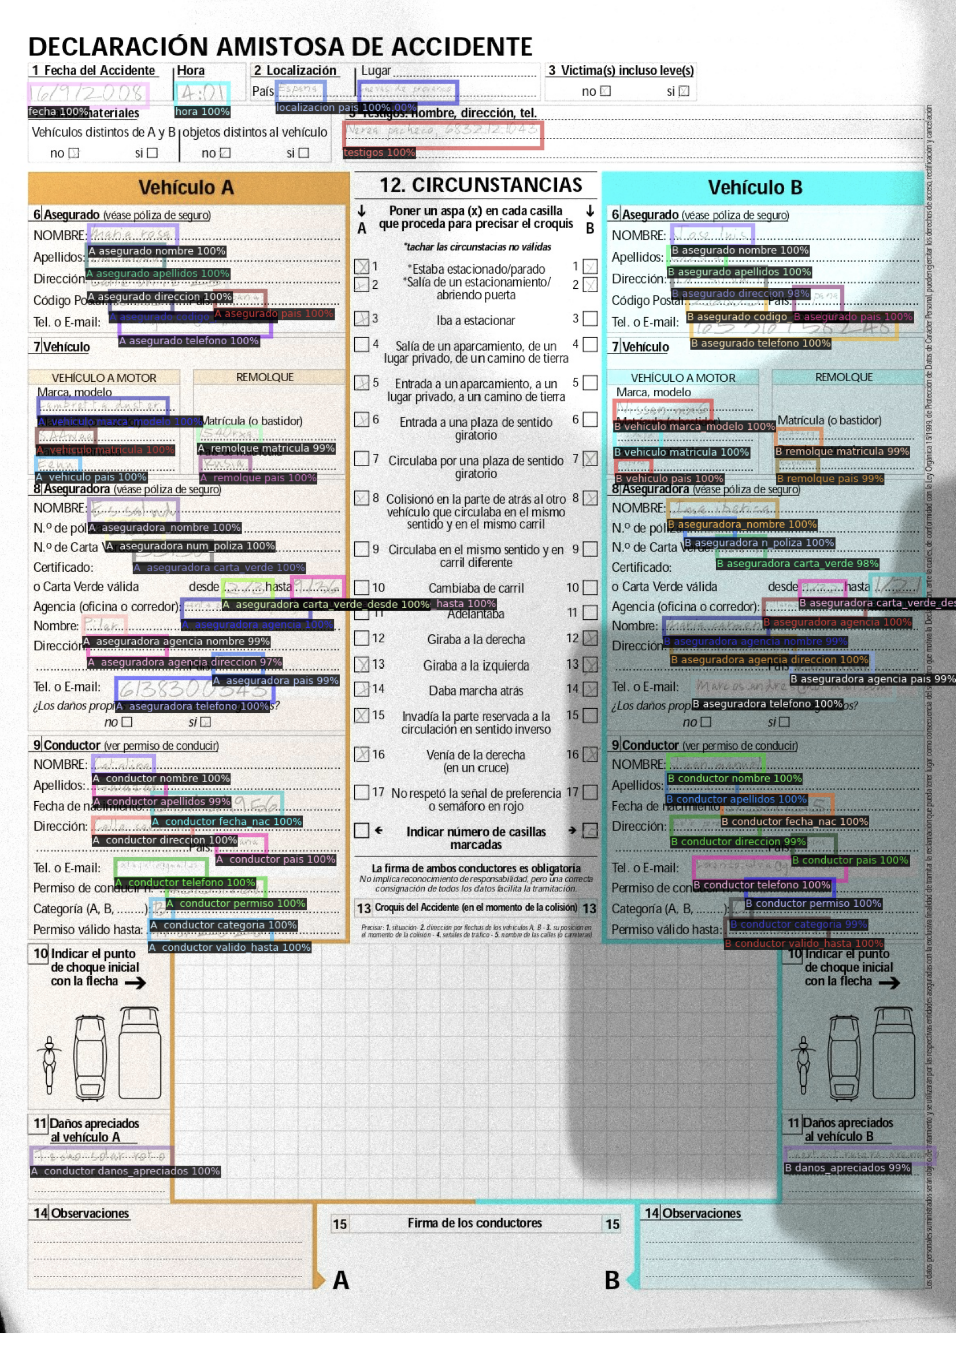

In [52]:
import session_info

session_info.show()